# YOLO with TensorFlow and keras


# 1. Initialisation

In [3]:
import os
import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import pandas as pd
from sklearn.model_selection import train_test_split
import csv

In [4]:
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.layers import Concatenate, concatenate, Dropout, LeakyReLU, Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda


gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus :
    tf.config.experimental.set_memory_growth(gpu, True)

## Connect with colab

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


# 2. HYPERPRAMETERS

In [7]:
# Parameters

LABELS           = LABELS=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
IMAGE_H, IMAGE_W = 512, 512
GRID_H,  GRID_W  = 16,16 # GRID size = IMAGE size / 32
BOX              = 5
CLASS            = len(LABELS)
SCORE_THRESHOLD  = 0.5
IOU_THRESHOLD    = 0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE   = 10
EPOCHS           = 300

columns=["path","width","height","label","xmin","ymin","xmax","ymax"]
LAMBDA_NOOBJECT  = 1
LAMBDA_OBJECT    = 5
LAMBDA_CLASS     = 1
LAMBDA_COORD     = 1

max_annot        = 0
# Train and validation directory
PATH='datasets/obd/hand sign dataset'

# 3. YOLO Neural Network

## 3.1 Build model

In [8]:
# Custom Keras layer

class SpaceToDepth(keras.layers.Layer):

    def __init__(self, block_size, **kwargs):
        self.block_size = block_size
        super(SpaceToDepth, self).__init__(**kwargs)

    def call(self, inputs):
        x = inputs
        batch, height, width, depth = K.int_shape(x)
        batch = -1
        reduced_height = height // self.block_size
        reduced_width = width // self.block_size
        y = K.reshape(x, (batch, reduced_height, self.block_size,
                             reduced_width, self.block_size, depth))
        z = K.permute_dimensions(y, (0, 1, 3, 2, 4, 5))
        t = K.reshape(z, (batch, reduced_height, reduced_width, depth * self.block_size **2))
        return t

    def compute_output_shape(self, input_shape):
        shape =  (input_shape[0], input_shape[1] // self.block_size, input_shape[2] // self.block_size,
                  input_shape[3] * self.block_size **2)
        return tf.TensorShape(shape)

In [36]:


input_image = tf.keras.layers.Input((IMAGE_H, IMAGE_W, 3), dtype='float32')

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)

skip_connection = SpaceToDepth(block_size=2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x) 

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_W, GRID_H, BOX, 4 + 1 + CLASS))(x)

model = keras.models.Model(input_image, output)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 512, 512, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 norm_1 (BatchNormalization)    (None, 512, 512, 32  128         ['conv_1[0][0]']                 
                                )                                                             

## 3.2 Read YOLO pretrained weights

In [37]:
class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4

In [38]:
weight_reader = WeightReader('datasets/yolo.weights')

In [39]:
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    conv_layer.trainable = True
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        norm_layer.trainable = True
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

In [40]:
layer   = model.layers[-2] # last convolutional layer
layer.trainable = True


weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

# 4. Data Preprocessing

## 4.1. Load Data & Parse annotations(xml) 

In [70]:
#load data paths
def load_data(path,train=True):
    ann_paths=[]
    
    
    

    if train :
        df=pd.read_csv(os.path.join(path,"train_labels.csv"),names=columns,header=1)
    else :
        df=pd.read_csv(os.path.join(path,"test_labels.csv"),names=columns,header=1)

    for _ , row in df.iterrows():
        image=row["path"]
        ann_path = image.rsplit(".", 1)[0]+".xml"
        if ann_path in os.listdir(path+"/annotations/"):
            ann_paths.append(ann_path)

    return ann_paths

#split_dataset
def load_dataset(path):
    train_images=load_data(path)
    images=load_data(path,False)

    test_images,val_images=train_test_split(images,test_size=0.5,random_state=18,shuffle=True)
    


    return train_images,val_images,test_images

def parse_annotation(labels,ann_paths,ann_dir=PATH+'/annotations/', img_dir=PATH+'/images/'):
    
    
    max_annot = 0
    imgs_name = []
    annots = []
    
    # Parse file
    for ann in sorted(ann_paths):
        annot_count = 0
        boxes = []
        tree = ET.parse(ann_dir + ann)
        for elem in tree.iter(): 
            if 'filename' in elem.tag:
                imgs_name.append(img_dir + elem.text)
            if 'width' in elem.tag:
                w = int(elem.text)
            if 'height' in elem.tag:
                h = int(elem.text)
            if 'object' in elem.tag : 
                x_scale = IMAGE_W / w
                y_scale = IMAGE_H / h                 
                box = np.zeros((5))
                for attr in list(elem):
                    if 'name' in attr.tag:
                        box[4] = labels.index(attr.text) + 1 # 0:label for no bounding box
                    if 'bndbox' in attr.tag:
                        annot_count += 1
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                box[0] = int(round(float(dim.text)*x_scale))
                            if 'ymin' in dim.tag:
                                box[1] = int(round(float(dim.text)*y_scale))
                            if 'xmax' in dim.tag:
                                box[2] = int(round(float(dim.text)*x_scale))
                            if 'ymax' in dim.tag:
                                box[3] = int(round(float(dim.text)*y_scale))
                boxes.append(np.asarray(box))
        
            
        
            
        annots.append(np.asarray(boxes))
        

        if annot_count > max_annot:
            max_annot = annot_count
           
    # Rectify annotations boxes : len -> max_annot
    imgs_name = np.array(imgs_name)  
    true_boxes = np.zeros((imgs_name.shape[0], max_annot, 5))
    for idx, boxes in enumerate(annots):
        true_boxes[idx, :boxes.shape[0], :5] = boxes
        
    return imgs_name, true_boxes

## 4.2. Build DataPipeline

In [71]:
def read_images(img_obj, true_boxes):
    image=tf.io.read_file(img_obj)
    image=tf.io.decode_jpeg(image)
    height,width,channels=image.shape
    #resize
    image=tf.image.resize(image,(IMAGE_H,IMAGE_W),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    if channels==1:
        image=tf.image.grayscale_to_rgb(image)
    #normalize
    image=tf.cast(image,dtype=tf.float32)/255
    return image, true_boxes

def tfData(ann_paths, batch_size):
   
    
    images_names, bbox = parse_annotation(LABELS,ann_paths)
    dataset = tf.data.Dataset.from_tensor_slices((images_names, bbox))    
    dataset = dataset.shuffle(len(images_names))
    dataset = dataset.repeat()
    dataset = dataset.map(read_images, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    print('-------------------')
    print('Dataset:')
    print(f'Images count: {len(images_names)}')
    print(f'Step per epoch: {len(images_names) // batch_size}')
    print(f'Images per epoch: {batch_size * (len(images_names) // batch_size)}')

    return dataset

train_images,val_images,test_images=load_dataset(PATH)
train_dataset= tfData(train_images, TRAIN_BATCH_SIZE)
val_dataset= tfData(val_images, VAL_BATCH_SIZE)

-------------------
Dataset:
Images count: 1511
Step per epoch: 188
Images per epoch: 1504
-------------------
Dataset:
Images count: 36
Step per epoch: 3
Images per epoch: 30


<Figure size 200x200 with 0 Axes>

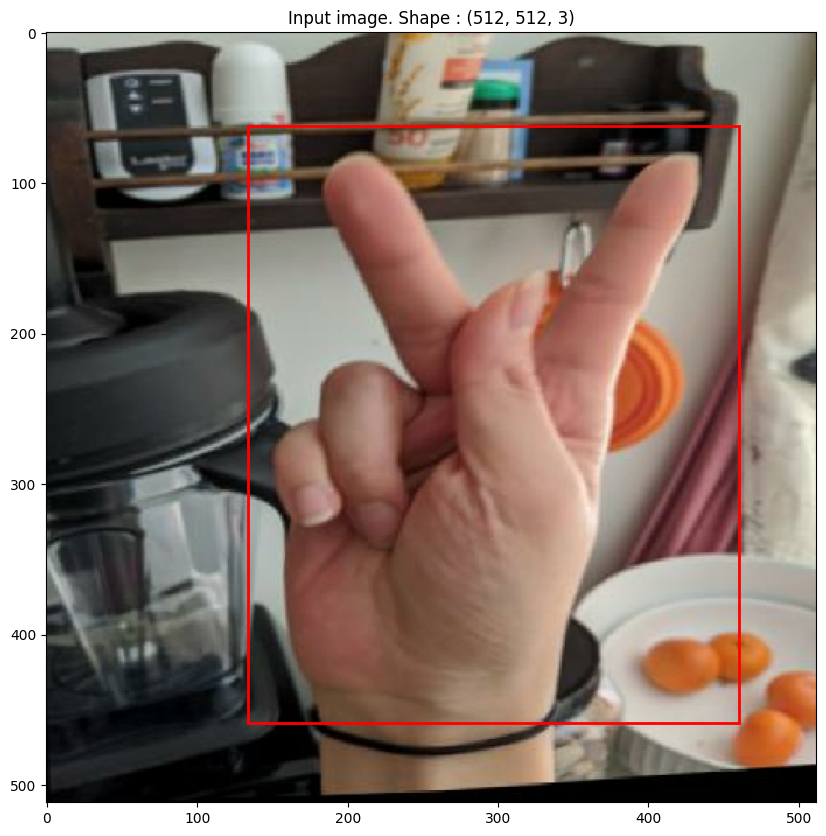

In [16]:
# Test dataset

def test_dataset(dataset):
    for batch in dataset:
        img = batch[0][0]
        label = batch[1][0]
        plt.figure(figsize=(2,2))
        f, (ax1) = plt.subplots(1,1, figsize=(10, 10))
        ax1.imshow(img)
        ax1.set_title(f'Input image. Shape : {img.shape}')
        for i in range(label.shape[0]):
            box = label[i,:]
            box = box.numpy()
            x = box[0]
            y = box[1]
            w = box[2] - box[0]
            h = box[3] - box[1]
            if box[4] == 1:
                color = (0, 1, 0)
            else:
                color = (1, 0, 0)
            rect = patches.Rectangle((x, y), w, h, linewidth = 2, edgecolor=color,facecolor='none')
            ax1.add_patch(rect)
        break

ds=train_dataset.take(2)
test_dataset(ds)

## 4.3. Process data to YOLO prediction format

In [12]:
def process_true_boxes(true_boxes, anchors):

    
    scale = IMAGE_W / GRID_W # scale = 32
    
    anchors_count = len(anchors) // 2
    anchors = np.array(anchors)
    anchors = anchors.reshape(anchors_count, 2)
    
    detector_mask = np.zeros((GRID_W, GRID_H, anchors_count, 1))
    matching_true_boxes = np.zeros((GRID_W, GRID_H, anchors_count, 5))
    
    # convert true_boxes numpy array
    true_boxes = true_boxes.numpy()
    
    true_boxes_grid = np.zeros(true_boxes.shape)
    
    # convert bounding box coords and localize bounding box
    for i, box in enumerate(true_boxes):
        # convert box coords to x, y, w, h and convert to grids coord
        w = (box[2] - box[0]) / scale
        h = (box[3] - box[1]) / scale    
        x = ((box[0] + box[2]) / 2) / scale
        y = ((box[1] + box[3]) / 2) / scale
        true_boxes_grid[i,...] = np.array([x, y, w, h, box[4]])
        if w * h > 0: # incase of labeling errors
            # calculate iou between box and each anchors and find best anchors
            best_iou = 0
            best_anchor = 0
            for i in range(anchors_count): 
                # iou (anchor and box x&y are 0,0)
                intersect = np.minimum(w, anchors[i,0]) * np.minimum(h, anchors[i,1])
                union = (anchors[i,0] * anchors[i,1]) + (w * h) - intersect
                iou = intersect / union
                if iou > best_iou:
                    best_iou = iou
                    best_anchor = i
            # localize box in detector_mask and matching true_boxes
            if best_iou > 0:
                x_coord = np.floor(x).astype('int')
                y_coord = np.floor(y).astype('int')
                detector_mask[y_coord, x_coord, best_anchor] = 1
                yolo_box = np.array([x, y, w, h, box[4]])
                matching_true_boxes[y_coord, x_coord, best_anchor] = yolo_box
    return matching_true_boxes, detector_mask, true_boxes_grid

In [13]:
def ground_truth_generator(dataset):
    
    for batch in dataset:
        # imgs
        imgs = batch[0]
        
        # true boxes
        true_boxes = batch[1]
        
        # matching_true_boxes and detector_mask
        batch_matching_true_boxes = []
        batch_detector_mask = []
        batch_true_boxes_grid = []
        
        for i in range(true_boxes.shape[0]):     
            one_matching_true_boxes, one_detector_mask, true_boxes_grid = process_true_boxes(true_boxes[i],
                                                                                           ANCHORS)
                                                                                          
            batch_matching_true_boxes.append(one_matching_true_boxes)
            batch_detector_mask.append(one_detector_mask)
            batch_true_boxes_grid.append(true_boxes_grid)
                
        detector_mask = tf.convert_to_tensor(np.array(batch_detector_mask), dtype='float32')
        matching_true_boxes = tf.convert_to_tensor(np.array(batch_matching_true_boxes), dtype='float32')
        true_boxes_grid = tf.convert_to_tensor(np.array(batch_true_boxes_grid), dtype='float32')
        
        # class one_hot
        matching_classes = K.cast(matching_true_boxes[..., 4], 'int32') 
        class_one_hot = K.one_hot(matching_classes, CLASS + 1)[:,:,:,:,1:]
        class_one_hot = tf.cast(class_one_hot, dtype='float32')
        
        batch = (imgs, detector_mask, matching_true_boxes, class_one_hot, true_boxes_grid)
        yield batch

train_gen = ground_truth_generator(train_dataset)
val_gen = ground_truth_generator(val_dataset)


# 5. Loss function Implementation

In [22]:
def iou(x1, y1, w1, h1, x2, y2, w2, h2):

    xmin1 = x1 - 0.5*w1
    xmax1 = x1 + 0.5*w1
    ymin1 = y1 - 0.5*h1
    ymax1 = y1 + 0.5*h1
    xmin2 = x2 - 0.5*w2
    xmax2 = x2 + 0.5*w2
    ymin2 = y2 - 0.5*h2
    ymax2 = y2 + 0.5*h2
    interx = np.minimum(xmax1, xmax2) - np.maximum(xmin1, xmin2)
    intery = np.minimum(ymax1, ymax2) - np.maximum(ymin1, ymin2)
    inter = interx * intery
    union = w1*h1 + w2*h2 - inter
    iou = inter / (union + 1e-6)
    return iou

In [23]:
# loss

def yolov2_loss(detector_mask, matching_true_boxes, class_one_hot, true_boxes_grid, y_pred, info=False):

    
    # anchors tensor
    anchors = np.array(ANCHORS)
    anchors = anchors.reshape(len(anchors) // 2, 2)
    
    # grid coords tensor
    coord_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    coord_y = tf.transpose(coord_x, (0,2,1,3,4))
    coords = tf.tile(tf.concat([coord_x,coord_y], -1), [y_pred.shape[0], 1, 1, 5, 1])
    
    # coordinate loss
    pred_xy = K.sigmoid(y_pred[:,:,:,:,0:2]) # adjust coords between 0 and 1
    pred_xy = (pred_xy + coords) # add cell coord for comparaison with ground truth. New coords in grid cell unit
    pred_wh = K.exp(y_pred[:,:,:,:,2:4]) * anchors # adjust width and height for comparaison with ground truth. New coords in grid cell unit
    #pred_wh = (pred_wh * anchors) # unit : grid cell
    nb_detector_mask = K.sum(tf.cast(detector_mask > 0.0, tf.float32))
    xy_loss = LAMBDA_COORD * K.sum(detector_mask * K.square(matching_true_boxes[...,:2] - pred_xy)) / (nb_detector_mask + 1e-6) # Non /2
    wh_loss = LAMBDA_COORD * K.sum(detector_mask * K.square(K.sqrt(matching_true_boxes[...,2:4]) - 
                                                            K.sqrt(pred_wh))) / (nb_detector_mask + 1e-6)
    coord_loss = xy_loss + wh_loss
    
    # class loss    
    pred_box_class = y_pred[..., 5:]
    true_box_class = tf.argmax(class_one_hot, -1)
    #class_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    class_loss = K.sparse_categorical_crossentropy(target=true_box_class, output=pred_box_class, from_logits=True)
    class_loss = K.expand_dims(class_loss, -1) * detector_mask
    class_loss = LAMBDA_CLASS * K.sum(class_loss) / (nb_detector_mask + 1e-6)
    
    # confidence loss
    pred_conf = K.sigmoid(y_pred[...,4:5])
    # for each detector : iou between prediction and ground truth
    x1 = matching_true_boxes[...,0]
    y1 = matching_true_boxes[...,1]
    w1 = matching_true_boxes[...,2]
    h1 = matching_true_boxes[...,3]
    x2 = pred_xy[...,0]
    y2 = pred_xy[...,1]
    w2 = pred_wh[...,0]
    h2 = pred_wh[...,1]
    ious = iou(x1, y1, w1, h1, x2, y2, w2, h2)
    ious = K.expand_dims(ious, -1)
     
    # for each detector : best ious between prediction and true_boxes (every bounding box of image)
    pred_xy = K.expand_dims(pred_xy, 4) # shape : m, GRID_W, GRID_H, BOX, 1, 2 
    pred_wh = K.expand_dims(pred_wh, 4)
    pred_wh_half = pred_wh / 2.
    pred_mins = pred_xy - pred_wh_half
    pred_maxes = pred_xy + pred_wh_half
    true_boxe_shape = K.int_shape(true_boxes_grid)
    true_boxes_grid = K.reshape(true_boxes_grid, [true_boxe_shape[0], 1, 1, 1, true_boxe_shape[1], true_boxe_shape[2]])
    true_xy = true_boxes_grid[...,0:2]
    true_wh = true_boxes_grid[...,2:4]
    true_wh_half = true_wh * 0.5
    true_mins = true_xy - true_wh_half
    true_maxes = true_xy + true_wh_half
    intersect_mins = K.maximum(pred_mins, true_mins) # shape : m, GRID_W, GRID_H, BOX, max_annot, 2 
    intersect_maxes = K.minimum(pred_maxes, true_maxes) # shape : m, GRID_W, GRID_H, BOX, max_annot, 2
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.) # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1] # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1] # shape : m, GRID_W, GRID_H, BOX, 1, 1
    true_areas = true_wh[..., 0] * true_wh[..., 1] # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    best_ious = K.max(iou_scores, axis=4)  # Best IOU scores.
    best_ious = K.expand_dims(best_ious) # shape : m, GRID_W, GRID_H, BOX, 1
    
    # no object confidence loss
    no_object_detection = K.cast(best_ious < 0.6, K.dtype(best_ious)) 
    noobj_mask = no_object_detection * (1 - detector_mask)
    nb_noobj_mask  = K.sum(tf.cast(noobj_mask  > 0.0, tf.float32))
    
    noobject_loss =  LAMBDA_NOOBJECT * K.sum(noobj_mask * K.square(-pred_conf)) / (nb_noobj_mask + 1e-6)
    # object confidence loss
    object_loss = LAMBDA_OBJECT * K.sum(detector_mask * K.square(ious - pred_conf)) / (nb_detector_mask + 1e-6)
    # total confidence loss
    conf_loss = noobject_loss + object_loss
    
    # total loss
    loss = conf_loss + class_loss + coord_loss
    sub_loss = [conf_loss, class_loss, coord_loss]  
    



              
    return loss, sub_loss

# 6. Training

In [25]:
# gradients
def grad(model, img, detector_mask, matching_true_boxes, class_one_hot, true_boxes, training=True):
    with tf.GradientTape() as tape:
        y_pred = model(img, training)
        loss, sub_loss = yolov2_loss(detector_mask, matching_true_boxes, class_one_hot, true_boxes, y_pred)
    return loss, sub_loss, tape.gradient(loss, model.trainable_variables)

# save weights
def save_best_weights(model, name, val_loss_avg):
    # delete existing weights file
    if f"{name}_asl.h5" in os.listdir("datasets"):
        os.remove(os.path.join("datasets",f"{name}_asl.h5"))
    # create new weights file
    model.save(f"datasets/{name}_asl.h5" )
# save progression in csv
def csv_save(epoch,loss_avg,val_loss_avg,subloss,val_subloss,name,writer):
    print(len(val_subloss))
    writer.writerow([epoch, loss_avg, val_loss_avg,subloss[0],val_subloss[0],subloss[1],val_subloss[1],subloss[2],val_subloss[2]])
#lr decay 
def lr_decay(epoch, lr):
    decay = 0.1 
    return lr * 1 / (1 + decay * epoch)
# log (tensorboard)
def log_loss(loss, val_loss, step):
    tf.summary.scalar('loss', loss, step)
    tf.summary.scalar('val_loss', val_loss, step)

In [26]:
# training
def train(epochs, model, train_dataset, val_dataset, steps_per_epoch_train, steps_per_epoch_val, train_name = 'train'):
   
    num_epochs = epochs
    steps_per_epoch_train = steps_per_epoch_train
    steps_per_epoch_val = steps_per_epoch_val
    train_loss_history = []
    val_loss_history = []
    val_subloss_history = []
    subloss_history = []
    best_val_loss = 1e6

    file = open(f'{train_name}.csv', 'w', newline='')
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train Loss", "Validation Loss","conf loss","val conf loss","class loss","val class loss","coord loss","val coord loss"])
    
    # optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
    # log (tensorboard)
    summary_writer = tf.summary.create_file_writer(os.path.join('logs/', train_name), flush_millis=20000)
    summary_writer.set_as_default()
    
    # training
    for epoch in range(num_epochs):
        epoch_loss = []
        epoch_val_loss = []
        epoch_sub_loss = []
        epoch_val_sub_loss = []
        print(f'Epoch {epoch} :')
        # train
        

        for batch_idx in range(steps_per_epoch_train): 
            img, detector_mask, matching_true_boxes, class_one_hot, true_boxes =  next(train_dataset)
           
            loss, subloss , grads = grad(model, img, detector_mask, matching_true_boxes, class_one_hot, true_boxes)
            epoch_sub_loss.append(sub_loss)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss.append(loss)
            print('-', end='')
        print(' | ', end='')
       # val
        for batch_idx in range(steps_per_epoch_val): 
            img, detector_mask, matching_true_boxes, class_one_hot, true_boxes =  next(val_dataset)
            loss, val_sub_loss, grads = grad(model, img, detector_mask, matching_true_boxes, class_one_hot, true_boxes, training=False)
            epoch_val_loss.append(loss)
            epoch_val_sub_loss.append(val_sub_loss)
            print('-', end='')

        loss_avg = np.mean(np.array(epoch_loss))
        val_loss_avg = np.mean(np.array(epoch_val_loss))
        sub_loss_avg = np.mean(np.array(epoch_sub_loss), axis=0)
        val_sub_loss_avg = np.mean(np.array(epoch_val_sub_loss), axis=0)

        train_loss_history.append(loss_avg)
        val_loss_history.append(val_loss_avg)
        subloss_history.append(sub_loss_avg)
        val_subloss_history.append(val_sub_loss_avg)


        
        # log
        log_loss(loss_avg, val_loss_avg, epoch)
       
        
        csv_save(epoch,loss_avg,val_loss_avg,sub_loss_avg,val_sub_loss_avg,train_name,writer)
        # save
        if val_loss_avg < best_val_loss:
            save_best_weights(model, train_name, val_loss_avg)
            best_val_loss = val_loss_avg
        
        print(f' loss = {loss_avg:.4f}, val_loss = {val_loss_avg:.4f} [conf={val_sub_loss_avg[0]:.4f}, class={ val_sub_loss_avg[1]:.4f}, coords={val_sub_loss_avg[2]:.4f}]')
        
    return [train_loss_history, val_loss_history,subloss_history,val_sub_loss,best_val_loss]

Epoch 0 :


---------- | --

3
 loss = 4.1317, val_loss = 4.1678 [conf=0.4229, class=3.2692, coords=0.4756]
Epoch 1 :
---------- | --3
 loss = 4.1058, val_loss = 4.2072 [conf=0.4172, class=3.2770, coords=0.5130]
Epoch 2 :
---------- | --

3
 loss = 4.0830, val_loss = 4.0697 [conf=0.3653, class=3.2417, coords=0.4627]
Epoch 3 :
---------- | --

3
 loss = 4.0386, val_loss = 3.9944 [conf=0.3367, class=3.2287, coords=0.4289]
Epoch 4 :
---------- | --3
 loss = 3.9962, val_loss = 4.0294 [conf=0.3733, class=3.2586, coords=0.3975]
Epoch 5 :
---------- | --

3
 loss = 3.9100, val_loss = 3.9527 [conf=0.3516, class=3.2122, coords=0.3889]
Epoch 6 :
---------- | --3
 loss = 3.9032, val_loss = 4.0235 [conf=0.2998, class=3.2443, coords=0.4795]
Epoch 7 :
---------- | --

3
 loss = 3.8528, val_loss = 3.8994 [conf=0.2839, class=3.2047, coords=0.4108]
Epoch 8 :
---------- | --3
 loss = 3.8424, val_loss = 3.9300 [conf=0.3161, class=3.2249, coords=0.3889]
Epoch 9 :
---------- | --

3
 loss = 3.7729, val_loss = 3.8430 [conf=0.2597, class=3.2091, coords=0.3741]
Epoch 10 :
---------- | --

3
 loss = 3.7340, val_loss = 3.8075 [conf=0.2832, class=3.1690, coords=0.3553]
Epoch 11 :
---------- | --

3
 loss = 3.7076, val_loss = 3.7939 [conf=0.2714, class=3.1599, coords=0.3626]
Epoch 12 :
---------- | --3
 loss = 3.6325, val_loss = 3.8039 [conf=0.2720, class=3.1778, coords=0.3542]
Epoch 13 :
---------- | --

3
 loss = 3.6245, val_loss = 3.6518 [conf=0.2461, class=3.1192, coords=0.2865]
Epoch 14 :
---------- | --3
 loss = 3.5900, val_loss = 3.6980 [conf=0.2303, class=3.1449, coords=0.3228]
Epoch 15 :
---------- | --3
 loss = 3.5172, val_loss = 3.6621 [conf=0.2475, class=3.0908, coords=0.3238]
Epoch 16 :
---------- | --3
 loss = 3.5260, val_loss = 3.6654 [conf=0.2492, class=3.0878, coords=0.3285]
Epoch 17 :
---------- | --

3
 loss = 3.5188, val_loss = 3.5251 [conf=0.2275, class=3.0330, coords=0.2646]
Epoch 18 :
---------- | --3
 loss = 3.4488, val_loss = 3.5958 [conf=0.2627, class=3.0094, coords=0.3237]
Epoch 19 :
---------- | --3
 loss = 3.2402, val_loss = 3.6152 [conf=0.2048, class=3.0958, coords=0.3146]
Epoch 20 :
---------- | --3
 loss = 3.3441, val_loss = 3.5414 [conf=0.2311, class=3.0510, coords=0.2593]
Epoch 21 :
---------- | --3
 loss = 3.1898, val_loss = 3.5453 [conf=0.2466, class=2.9379, coords=0.3609]
Epoch 22 :
---------- | --3
 loss = 3.2083, val_loss = 3.5314 [conf=0.2375, class=3.0152, coords=0.2787]
Epoch 23 :
---------- | --

3
 loss = 3.2907, val_loss = 3.5234 [conf=0.2255, class=2.9897, coords=0.3083]
Epoch 24 :
---------- | --

3
 loss = 3.1618, val_loss = 3.4639 [conf=0.2277, class=2.9357, coords=0.3005]
Epoch 25 :
---------- | --

3
 loss = 3.1858, val_loss = 3.3029 [conf=0.1972, class=2.8189, coords=0.2868]
Epoch 26 :
---------- | --3
 loss = 3.1037, val_loss = 3.4083 [conf=0.2394, class=2.8870, coords=0.2819]
Epoch 27 :
---------- | --

3
 loss = 2.9906, val_loss = 3.1603 [conf=0.2330, class=2.6604, coords=0.2670]
Epoch 28 :
---------- | --3
 loss = 2.9254, val_loss = 3.4948 [conf=0.1920, class=2.9569, coords=0.3459]
Epoch 29 :
---------- | --3
 loss = 2.9449, val_loss = 3.2242 [conf=0.2452, class=2.7018, coords=0.2772]
Epoch 30 :
---------- | --3
 loss = 2.8898, val_loss = 3.5147 [conf=0.2148, class=2.8828, coords=0.4170]
Epoch 31 :
---------- | --

3
 loss = 2.7818, val_loss = 3.1214 [conf=0.2307, class=2.5402, coords=0.3506]
Epoch 32 :
---------- | --3
 loss = 2.9472, val_loss = 3.2481 [conf=0.2476, class=2.7205, coords=0.2801]
Epoch 33 :
---------- | --

3
 loss = 2.6996, val_loss = 3.1151 [conf=0.2444, class=2.5417, coords=0.3290]
Epoch 34 :
---------- | --

3
 loss = 2.7681, val_loss = 3.0781 [conf=0.2162, class=2.5421, coords=0.3198]
Epoch 35 :
---------- | --

3
 loss = 2.6244, val_loss = 2.9563 [conf=0.2374, class=2.4158, coords=0.3031]
Epoch 36 :
---------- | --3
 loss = 2.6026, val_loss = 3.0658 [conf=0.2302, class=2.5172, coords=0.3185]
Epoch 37 :
---------- | --

3
 loss = 2.5735, val_loss = 2.9435 [conf=0.2081, class=2.3592, coords=0.3762]
Epoch 38 :
---------- | --3
 loss = 2.3731, val_loss = 3.0153 [conf=0.2086, class=2.5225, coords=0.2842]
Epoch 39 :
---------- | --3
 loss = 2.2386, val_loss = 3.0661 [conf=0.2256, class=2.4089, coords=0.4316]
Epoch 40 :
---------- | --

3
 loss = 2.4481, val_loss = 2.8420 [conf=0.2303, class=2.3281, coords=0.2835]
Epoch 41 :
---------- | --

3
 loss = 2.5422, val_loss = 2.6628 [conf=0.2170, class=2.1673, coords=0.2785]
Epoch 42 :
---------- | --3
 loss = 2.2546, val_loss = 3.1334 [conf=0.2202, class=2.4745, coords=0.4386]
Epoch 43 :
---------- | --3
 loss = 2.2868, val_loss = 2.8983 [conf=0.2178, class=2.2973, coords=0.3832]
Epoch 44 :
---------- | --

3
 loss = 2.3826, val_loss = 2.6059 [conf=0.1969, class=2.1024, coords=0.3067]
Epoch 45 :
---------- | --3
 loss = 2.2708, val_loss = 2.6570 [conf=0.2099, class=2.1129, coords=0.3342]
Epoch 46 :
---------- | --3
 loss = 2.0139, val_loss = 2.6243 [conf=0.1856, class=2.1528, coords=0.2859]
Epoch 47 :
---------- | --3
 loss = 2.1891, val_loss = 2.6839 [conf=0.1872, class=2.1704, coords=0.3263]
Epoch 48 :
---------- | --3
 loss = 2.1514, val_loss = 2.6914 [conf=0.2145, class=2.1501, coords=0.3269]
Epoch 49 :
---------- | --

3
 loss = 1.9666, val_loss = 2.5345 [conf=0.1741, class=2.0837, coords=0.2767]
Epoch 50 :
---------- | --

3
 loss = 2.2258, val_loss = 2.4186 [conf=0.2540, class=1.7580, coords=0.4065]
Epoch 51 :
---------- | --3
 loss = 2.1349, val_loss = 2.6437 [conf=0.1832, class=2.1261, coords=0.3344]
Epoch 52 :
---------- | --3
 loss = 1.9869, val_loss = 2.6355 [conf=0.2182, class=2.0471, coords=0.3701]
Epoch 53 :
---------- | --3
 loss = 1.9826, val_loss = 2.4340 [conf=0.2006, class=1.8289, coords=0.4045]
Epoch 54 :
---------- | --3
 loss = 2.0822, val_loss = 2.7042 [conf=0.2109, class=2.1308, coords=0.3625]
Epoch 55 :
---------- | --

3
 loss = 1.8794, val_loss = 2.2658 [conf=0.1879, class=1.7511, coords=0.3268]
Epoch 56 :
---------- | --3
 loss = 1.7911, val_loss = 2.4829 [conf=0.2133, class=1.9016, coords=0.3680]
Epoch 57 :
---------- | --

3
 loss = 1.8494, val_loss = 2.1623 [conf=0.2346, class=1.5861, coords=0.3416]
Epoch 58 :
---------- | --3
 loss = 1.7992, val_loss = 2.5581 [conf=0.1869, class=2.0416, coords=0.3295]
Epoch 59 :
---------- | --3
 loss = 1.7629, val_loss = 2.1786 [conf=0.1881, class=1.6537, coords=0.3368]
Epoch 60 :
---------- | --3
 loss = 1.7038, val_loss = 2.4548 [conf=0.2530, class=1.7768, coords=0.4250]
Epoch 61 :
---------- | --

3
 loss = 1.8131, val_loss = 2.1487 [conf=0.2024, class=1.5866, coords=0.3596]
Epoch 62 :
---------- | --3
 loss = 1.7830, val_loss = 2.3958 [conf=0.2275, class=1.8936, coords=0.2747]
Epoch 63 :
---------- | --3
 loss = 1.6751, val_loss = 2.3411 [conf=0.2340, class=1.7623, coords=0.3449]
Epoch 64 :
---------- | --

3
 loss = 1.7763, val_loss = 2.0609 [conf=0.2288, class=1.3985, coords=0.4336]
Epoch 65 :
---------- | --3
 loss = 1.6515, val_loss = 2.6279 [conf=0.2616, class=1.8922, coords=0.4741]
Epoch 66 :
---------- | --3
 loss = 1.7565, val_loss = 2.1102 [conf=0.2182, class=1.5296, coords=0.3625]
Epoch 67 :
---------- | --3
 loss = 1.6476, val_loss = 2.1572 [conf=0.2416, class=1.5283, coords=0.3873]
Epoch 68 :
---------- | --3
 loss = 1.5556, val_loss = 2.6442 [conf=0.1786, class=2.0384, coords=0.4273]
Epoch 69 :
---------- | --3
 loss = 1.4384, val_loss = 2.0788 [conf=0.1839, class=1.5319, coords=0.3630]
Epoch 70 :
---------- | --

3
 loss = 1.3727, val_loss = 1.8645 [conf=0.2146, class=1.3958, coords=0.2541]
Epoch 71 :
---------- | --3
 loss = 1.6006, val_loss = 2.2785 [conf=0.2393, class=1.7446, coords=0.2946]
Epoch 72 :
---------- | --3
 loss = 1.4231, val_loss = 2.1387 [conf=0.2161, class=1.3726, coords=0.5501]
Epoch 73 :
---------- | --3
 loss = 1.6147, val_loss = 2.3698 [conf=0.3223, class=1.7727, coords=0.2748]
Epoch 74 :
---------- | --3
 loss = 1.5312, val_loss = 1.9120 [conf=0.2155, class=1.3812, coords=0.3153]
Epoch 75 :
---------- | --3
 loss = 1.3635, val_loss = 2.6578 [conf=0.2261, class=1.9443, coords=0.4874]
Epoch 76 :
---------- | --

3
 loss = 1.4700, val_loss = 1.8539 [conf=0.1657, class=1.3706, coords=0.3175]
Epoch 77 :
---------- | --

3
 loss = 1.4785, val_loss = 1.8109 [conf=0.1916, class=1.3802, coords=0.2390]
Epoch 78 :
---------- | --3
 loss = 1.2095, val_loss = 2.3355 [conf=0.2190, class=1.7241, coords=0.3924]
Epoch 79 :
---------- | --3
 loss = 1.3604, val_loss = 1.8679 [conf=0.1808, class=1.3408, coords=0.3463]
Epoch 80 :
---------- | --3
 loss = 1.2915, val_loss = 1.8644 [conf=0.1800, class=1.4096, coords=0.2748]
Epoch 81 :
---------- | --3
 loss = 1.2797, val_loss = 2.1515 [conf=0.2180, class=1.6383, coords=0.2952]
Epoch 82 :
---------- | --

3
 loss = 1.2422, val_loss = 1.6665 [conf=0.1626, class=1.1822, coords=0.3217]
Epoch 83 :
---------- | --3
 loss = 1.2241, val_loss = 2.0239 [conf=0.2279, class=1.4451, coords=0.3508]
Epoch 84 :
---------- | --3
 loss = 1.2877, val_loss = 2.0408 [conf=0.1613, class=1.6460, coords=0.2335]
Epoch 85 :
---------- | --3
 loss = 1.2729, val_loss = 1.8219 [conf=0.1791, class=1.3581, coords=0.2846]
Epoch 86 :
---------- | --

3
 loss = 1.2658, val_loss = 1.5259 [conf=0.1838, class=1.0930, coords=0.2490]
Epoch 87 :
---------- | --3
 loss = 1.1409, val_loss = 2.1426 [conf=0.1755, class=1.6763, coords=0.2907]
Epoch 88 :
---------- | --3
 loss = 1.1752, val_loss = 1.5464 [conf=0.1913, class=1.0779, coords=0.2772]
Epoch 89 :
---------- | --3
 loss = 1.3539, val_loss = 2.0772 [conf=0.2049, class=1.5667, coords=0.3057]
Epoch 90 :
---------- | --3
 loss = 1.1758, val_loss = 1.6411 [conf=0.1676, class=1.1517, coords=0.3218]
Epoch 91 :
---------- | --3
 loss = 1.0310, val_loss = 2.1762 [conf=0.1717, class=1.6970, coords=0.3076]
Epoch 92 :
---------- | --3
 loss = 1.2161, val_loss = 1.8331 [conf=0.1885, class=1.3495, coords=0.2951]
Epoch 93 :
---------- | --3
 loss = 1.1077, val_loss = 1.5715 [conf=0.2053, class=1.1070, coords=0.2591]
Epoch 94 :
---------- | --3
 loss = 1.1505, val_loss = 1.6988 [conf=0.2352, class=1.2028, coords=0.2607]
Epoch 95 :
---------- | --3
 loss = 1.0960, val_loss = 1.6848 [conf=0.2272, class

3
 loss = 1.0015, val_loss = 1.2809 [conf=0.1580, class=0.8618, coords=0.2611]
Epoch 106 :
---------- | --3
 loss = 0.9760, val_loss = 1.7353 [conf=0.1753, class=1.1632, coords=0.3968]
Epoch 107 :
---------- | --3
 loss = 1.0173, val_loss = 1.9128 [conf=0.1826, class=1.4338, coords=0.2963]
Epoch 108 :
---------- | --3
 loss = 0.9630, val_loss = 1.9116 [conf=0.1859, class=1.4987, coords=0.2271]
Epoch 109 :
---------- | --3
 loss = 0.9599, val_loss = 1.4515 [conf=0.2321, class=0.9552, coords=0.2641]
Epoch 110 :
---------- | --3
 loss = 0.8353, val_loss = 2.1328 [conf=0.1819, class=1.6489, coords=0.3020]
Epoch 111 :
---------- | --3
 loss = 0.9911, val_loss = 1.5124 [conf=0.1662, class=1.0518, coords=0.2944]
Epoch 112 :
---------- | --3
 loss = 0.8468, val_loss = 1.6979 [conf=0.1402, class=1.3129, coords=0.2448]
Epoch 113 :
---------- | --3
 loss = 0.9803, val_loss = 1.3220 [conf=0.1959, class=0.9094, coords=0.2167]
Epoch 114 :
---------- | --3
 loss = 0.7660, val_loss = 1.5876 [conf=0.20

3
 loss = 0.8048, val_loss = 1.2393 [conf=0.1754, class=0.8683, coords=0.1957]
Epoch 123 :
---------- | --3
 loss = 0.8767, val_loss = 1.6973 [conf=0.1560, class=1.2593, coords=0.2820]
Epoch 124 :
---------- | --3
 loss = 0.8388, val_loss = 1.4669 [conf=0.1421, class=1.0403, coords=0.2845]
Epoch 125 :
---------- | --3
 loss = 0.9003, val_loss = 1.9411 [conf=0.1914, class=1.4730, coords=0.2767]
Epoch 126 :
---------- | --3
 loss = 0.7125, val_loss = 1.6409 [conf=0.1917, class=1.1638, coords=0.2853]
Epoch 127 :
---------- | --3
 loss = 0.7565, val_loss = 1.4428 [conf=0.1753, class=0.9710, coords=0.2965]
Epoch 128 :
---------- | --

3
 loss = 0.8265, val_loss = 1.1199 [conf=0.1451, class=0.7507, coords=0.2241]
Epoch 129 :
---------- | --3
 loss = 0.7072, val_loss = 1.8782 [conf=0.1982, class=1.4395, coords=0.2405]
Epoch 130 :
---------- | --3
 loss = 0.6647, val_loss = 1.3876 [conf=0.1773, class=0.9730, coords=0.2373]
Epoch 131 :
---------- | --3
 loss = 0.7431, val_loss = 1.9783 [conf=0.1933, class=1.4880, coords=0.2970]
Epoch 132 :
---------- | --3
 loss = 0.6893, val_loss = 1.6582 [conf=0.1844, class=1.2025, coords=0.2713]
Epoch 133 :
---------- | --3
 loss = 0.8713, val_loss = 1.4569 [conf=0.1621, class=0.9979, coords=0.2968]
Epoch 134 :
---------- | --3
 loss = 0.7998, val_loss = 1.5084 [conf=0.1576, class=1.1015, coords=0.2493]
Epoch 135 :
---------- | --3
 loss = 0.7500, val_loss = 1.3183 [conf=0.1414, class=0.9380, coords=0.2389]
Epoch 136 :
---------- | --3
 loss = 0.7169, val_loss = 1.6981 [conf=0.1423, class=1.3074, coords=0.2484]
Epoch 137 :
---------- | --3
 loss = 0.7230, val_loss = 1.7780 [conf=0.18

3
 loss = 0.6093, val_loss = 1.0053 [conf=0.1589, class=0.6800, coords=0.1664]
Epoch 163 :
---------- | --3
 loss = 0.6386, val_loss = 1.7744 [conf=0.1708, class=1.3610, coords=0.2427]
Epoch 164 :
---------- | --3
 loss = 0.6102, val_loss = 1.4052 [conf=0.1587, class=0.9698, coords=0.2767]
Epoch 165 :
---------- | --3
 loss = 0.5415, val_loss = 1.3215 [conf=0.1269, class=0.9745, coords=0.2201]
Epoch 166 :
---------- | --3
 loss = 0.5674, val_loss = 1.5484 [conf=0.1616, class=1.1981, coords=0.1887]
Epoch 167 :
---------- | --

3
 loss = 0.5226, val_loss = 0.9814 [conf=0.1774, class=0.6089, coords=0.1951]
Epoch 168 :
---------- | --3
 loss = 0.6321, val_loss = 1.2738 [conf=0.1249, class=0.9034, coords=0.2454]
Epoch 169 :
---------- | --3
 loss = 0.5858, val_loss = 1.8003 [conf=0.1570, class=1.4307, coords=0.2126]
Epoch 170 :
---------- | --3
 loss = 0.5871, val_loss = 1.2458 [conf=0.1157, class=0.9224, coords=0.2078]
Epoch 171 :
---------- | --3
 loss = 0.6315, val_loss = 1.2340 [conf=0.1350, class=0.8621, coords=0.2368]
Epoch 172 :
---------- | --3
 loss = 0.6060, val_loss = 1.5357 [conf=0.1246, class=1.2425, coords=0.1686]
Epoch 173 :
---------- | --3
 loss = 0.5924, val_loss = 1.1930 [conf=0.1294, class=0.8744, coords=0.1892]
Epoch 174 :
---------- | --3
 loss = 0.5536, val_loss = 1.4846 [conf=0.1580, class=1.1121, coords=0.2145]
Epoch 175 :
---------- | --3
 loss = 0.5973, val_loss = 1.2162 [conf=0.1263, class=0.8814, coords=0.2084]
Epoch 176 :
---------- | --3
 loss = 0.4893, val_loss = 1.3967 [conf=0.12

3
 loss = 0.4954, val_loss = 0.8812 [conf=0.1033, class=0.5887, coords=0.1892]
Epoch 184 :
---------- | --3
 loss = 0.5219, val_loss = 1.4713 [conf=0.1408, class=1.1232, coords=0.2074]
Epoch 185 :
---------- | --3
 loss = 0.5616, val_loss = 1.3511 [conf=0.1470, class=1.0151, coords=0.1889]
Epoch 186 :
---------- | --3
 loss = 0.5368, val_loss = 1.5317 [conf=0.1696, class=1.1091, coords=0.2530]
Epoch 187 :
---------- | --3
 loss = 0.5811, val_loss = 1.2111 [conf=0.1041, class=0.8904, coords=0.2165]
Epoch 188 :
---------- | --3
 loss = 0.5001, val_loss = 1.4354 [conf=0.1603, class=1.0458, coords=0.2294]
Epoch 189 :
---------- | --3
 loss = 0.5630, val_loss = 1.2966 [conf=0.1265, class=0.9799, coords=0.1901]
Epoch 190 :
---------- | --3
 loss = 0.5090, val_loss = 1.1698 [conf=0.1226, class=0.8569, coords=0.1903]
Epoch 191 :
---------- | --3
 loss = 0.5681, val_loss = 1.5273 [conf=0.1653, class=1.1511, coords=0.2108]
Epoch 192 :
---------- | --3
 loss = 0.4797, val_loss = 0.9960 [conf=0.15

3
 loss = 0.4550, val_loss = 0.8519 [conf=0.0964, class=0.6023, coords=0.1532]
Epoch 215 :
---------- | --3
 loss = 0.4208, val_loss = 1.4994 [conf=0.1043, class=1.1814, coords=0.2137]
Epoch 216 :
---------- | --3
 loss = 0.4490, val_loss = 1.4988 [conf=0.1067, class=1.2100, coords=0.1821]
Epoch 217 :
---------- | --

3
 loss = 0.4659, val_loss = 0.7991 [conf=0.1108, class=0.5482, coords=0.1402]
Epoch 218 :
---------- | --3
 loss = 0.5030, val_loss = 1.0204 [conf=0.1156, class=0.6691, coords=0.2357]
Epoch 219 :
---------- | --3
 loss = 0.4523, val_loss = 1.4682 [conf=0.1263, class=1.0621, coords=0.2798]
Epoch 220 :
---------- | --3
 loss = 0.4347, val_loss = 1.1452 [conf=0.1159, class=0.8102, coords=0.2192]
Epoch 221 :
---------- | --3
 loss = 0.4193, val_loss = 1.5345 [conf=0.1084, class=1.2081, coords=0.2180]
Epoch 222 :
---------- | --3
 loss = 0.4435, val_loss = 1.2821 [conf=0.1220, class=0.9814, coords=0.1788]
Epoch 223 :
---------- | --3
 loss = 0.4728, val_loss = 1.0265 [conf=0.1392, class=0.7165, coords=0.1708]
Epoch 224 :
---------- | --3
 loss = 0.3895, val_loss = 1.3306 [conf=0.1190, class=1.0186, coords=0.1930]
Epoch 225 :
---------- | --3
 loss = 0.4390, val_loss = 0.8604 [conf=0.1275, class=0.5512, coords=0.1817]
Epoch 226 :
---------- | --3
 loss = 0.4290, val_loss = 1.7067 [conf=0.10

3
 loss = 0.3307, val_loss = 0.7418 [conf=0.0816, class=0.5248, coords=0.1355]
Epoch 277 :
---------- | --3
 loss = 0.3259, val_loss = 1.5160 [conf=0.1265, class=1.2164, coords=0.1731]
Epoch 278 :
---------- | --3
 loss = 0.2912, val_loss = 1.0287 [conf=0.0946, class=0.7567, coords=0.1775]
Epoch 279 :
---------- | --3
 loss = 0.3614, val_loss = 1.0117 [conf=0.1220, class=0.7056, coords=0.1841]
Epoch 280 :
---------- | --3
 loss = 0.3908, val_loss = 1.3854 [conf=0.1206, class=1.1103, coords=0.1546]
Epoch 281 :
---------- | --3
 loss = 0.3362, val_loss = 0.8543 [conf=0.1067, class=0.5621, coords=0.1855]
Epoch 282 :
---------- | --3
 loss = 0.3546, val_loss = 1.3762 [conf=0.0885, class=1.1062, coords=0.1816]
Epoch 283 :
---------- | --3
 loss = 0.3313, val_loss = 1.1426 [conf=0.0941, class=0.8743, coords=0.1741]
Epoch 284 :
---------- | --3
 loss = 0.3324, val_loss = 1.3636 [conf=0.1266, class=1.0571, coords=0.1799]
Epoch 285 :
---------- | --3
 loss = 0.3132, val_loss = 1.0514 [conf=0.08

3
 loss = 0.3537, val_loss = 0.6673 [conf=0.1016, class=0.4014, coords=0.1643]
Epoch 291 :
---------- | --3
 loss = 0.3482, val_loss = 1.2575 [conf=0.0783, class=1.0014, coords=0.1778]
Epoch 292 :
---------- | --3
 loss = 0.3098, val_loss = 1.1887 [conf=0.0945, class=0.9235, coords=0.1706]
Epoch 293 :
---------- | --3
 loss = 0.3284, val_loss = 1.1650 [conf=0.0950, class=0.8790, coords=0.1911]
Epoch 294 :
---------- | --3
 loss = 0.3067, val_loss = 1.0160 [conf=0.1139, class=0.7502, coords=0.1518]
Epoch 295 :
---------- | --3
 loss = 0.3434, val_loss = 1.3918 [conf=0.1134, class=1.1455, coords=0.1329]
Epoch 296 :
---------- | --3
 loss = 0.3381, val_loss = 1.0161 [conf=0.1027, class=0.7380, coords=0.1754]
Epoch 297 :
---------- | --3
 loss = 0.3459, val_loss = 1.5255 [conf=0.1302, class=1.2376, coords=0.1577]
Epoch 298 :
---------- | --3
 loss = 0.3233, val_loss = 1.0512 [conf=0.1323, class=0.6895, coords=0.2293]
Epoch 299 :
---------- | --3
 loss = 0.3459, val_loss = 1.0591 [conf=0.08

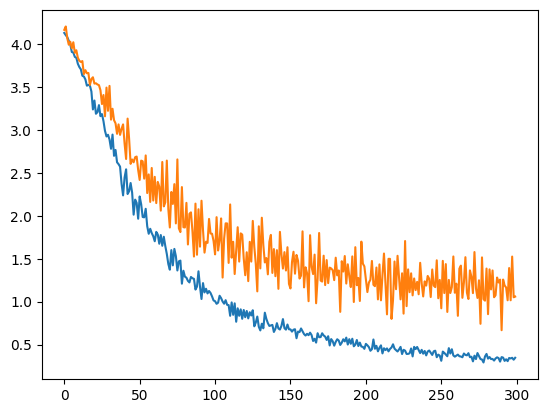

In [27]:
results = train(EPOCHS, model, train_gen, val_gen, 10, 2, 'training_vis2')



# 7. Evaluation

## 7.1. loss visualization

0.6673068


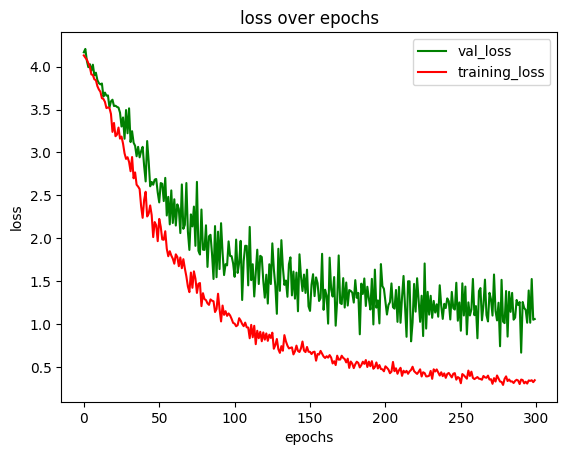

<Figure size 2000x1000 with 0 Axes>

In [33]:
print(results[-1])
val_loss=np.array(results[1])
loss=np.array(results[0])
x=np.arange(loss.shape[0])

ax=plt.subplot()
plt.figure(figsize=(20,10))
ax.set_title("loss over epochs")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.plot(x,val_loss,label="val_loss",c="green")
ax.plot(x,loss,label="training_loss",c="red")
ax.legend()

## 7.2. load tensorboard

In [ ]:
!tensorboard --logdir=logs/

## 7.3. load model and test on custom pictures

In [45]:
import matplotlib.image as mpimg
def predict_yolo(file, model, score_threshold, iou_threshold):

    # load image
    image = cv2.imread(file)
    image = cv2.resize(image, (IMAGE_W, IMAGE_H))
    print(image.shape)
    input_image = image[:,:,::-1]
    input_image = image / 255.
    input_image = np.expand_dims(input_image, 0)

    # prediction
    y_pred = model.predict_on_batch(input_image)

    # post prediction process
    # grid coords tensor
    coord_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    coord_y = tf.transpose(coord_x, (0,2,1,3,4))
    coords = tf.tile(tf.concat([coord_x,coord_y], -1), [TRAIN_BATCH_SIZE, 1, 1, 5, 1])
    dims = K.cast_to_floatx(K.int_shape(y_pred)[1:3])
    dims = K.reshape(dims,(1,1,1,1,2))
    # anchors tensor
    anchors = np.array(ANCHORS)
    anchors = anchors.reshape(len(anchors) // 2, 2)
    # pred_xy and pred_wh shape (m, GRID_W, GRID_H, Anchors, 2)
    pred_xy = K.sigmoid(y_pred[:,:,:,:,0:2])
    pred_xy = (pred_xy + coords)
    pred_xy = pred_xy / dims
    pred_wh = K.exp(y_pred[:,:,:,:,2:4])
    pred_wh = (pred_wh * anchors)
    pred_wh = pred_wh / dims
    # pred_confidence
    box_conf = K.sigmoid(y_pred[:,:,:,:,4:5])  


    # pred_class
    box_class_prob = K.softmax(y_pred[:,:,:,:,5:])

    # Reshape
    pred_xy = pred_xy[0,...]
    pred_wh = pred_wh[0,...]
    box_conf = box_conf[0,...]
    box_class_prob = box_class_prob[0,...]

    # Convert box coords from x,y,w,h to x1,y1,x2,y2
    box_xy1 = pred_xy - 0.5 * pred_wh
    box_xy2 = pred_xy + 0.5 * pred_wh
    boxes = K.concatenate((box_xy1, box_xy2), axis=-1)

    # Filter boxes
    box_scores = box_conf * box_class_prob
    box_classes = K.argmax(box_scores, axis=-1) # best score index
    box_class_scores = K.max(box_scores, axis=-1) # best score
    prediction_mask = box_class_scores >= score_threshold
    boxes = tf.boolean_mask(boxes, prediction_mask)
    scores = tf.boolean_mask(box_class_scores, prediction_mask)
    classes = tf.boolean_mask(box_classes, prediction_mask)

    # Scale box to image shape
    boxes = boxes * IMAGE_H

    # Non Max Supression
    selected_idx = tf.image.non_max_suppression(boxes, scores, 50, iou_threshold=iou_threshold)
    boxes = K.gather(boxes, selected_idx)
    scores = K.gather(scores, selected_idx)
    classes = K.gather(classes, selected_idx)
    
    # Draw image
    plt.figure(figsize=(2,2))
    f, (ax1) = plt.subplots(1,1, figsize=(5, 10))
    ax1.imshow(image[:,:,::-1])
    count_detected = boxes.shape[0]
    ax1.set_title(f'Detected objects count : {count_detected}')
    for i in range(count_detected):
        box = boxes[i,...]
        x = box[0]
        y = box[1]
        w = box[2] - box[0]
        h = box[3] - box[1]
        classe = classes[i].numpy()
        ax1.text(x.numpy(), y.numpy(), LABELS[classe], color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.7))
        color = (1, 0, 0)
        rect = patches.Rectangle((x.numpy(), y.numpy()), w.numpy(), h.numpy(), linewidth = 3, edgecolor=color,facecolor='none')
        ax1.add_patch(rect)

In [69]:

score = SCORE_THRESHOLD
iou_threshold = IOU_THRESHOLD

from keras.utils import custom_object_scope

# Define the custom layer(s)


# Load the trainable model model with custom layer
trainable_model = keras.models.load_model('datasets/training_vis2_asl.h5', custom_objects={'SpaceToDepth': SpaceToDepth})
score = 0.3
iou_threshold = 0.4

file = "datasets/obd/o.png"
predict_yolo(file, trainable_model, score, iou_threshold)

error: ignored